In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch.distributions import Normal, MultivariateNormal as MNormal
import ot
import jax
import matplotlib.pyplot as plt
import seaborn as sns

from ex2mcmc.sampling_utils.adaptive_mc import Ex2MCMC, FlowMCMC
from ex2mcmc.models.rnvp import RNVP
from ex2mcmc.models.rnvp_minimal import MinimalRNVP
from ex2mcmc.samplers import ex2mcmc, flex2mcmc
from ex2mcmc.sampling_utils.metrics import ESS, acl_spectrum
from ex2mcmc.sampling_utils.total_variation import average_total_variation
from ex2mcmc.utils.general_utils import random_seed

from ex2mcmc.pyro_samplers import NUTS, HMC


sns.set_theme('talk', style="white")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
class Funnel(object):
    """
    Funnel distribution.

    “Slice sampling”. R. Neal, Annals of statistics, 705 (2003) https://doi.org/10.1214/aos/1056562461

    Args:
        dim - dimension
        nu - parameter
    """
    def __init__(self, dim: int, a: float=3):
        self._dim = dim
        self.a = a
        self.normal_last = Normal(0, a)

    @property
    def dim(self) -> int:
        return self._dim
    
    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """

        normal_first = Normal(torch.zeros(x.shape[:-1], device=x.device), torch.exp(x[..., 0] / 2.))
        return normal_first.log_prob(x[..., 1:].permute(-1, *range(x.ndim-1))).sum(0) + \
            self.normal_last.log_prob(x[..., 0])

    def plot_2d_countour(self, ax):
        x = np.linspace(-15, 15, 100)
        y = np.linspace(-10, 10, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])

        #levels = np.quantile(Z, np.linspace(0.9, 0.99, 5))
        ax.contour(Y, X, Z.exp(), 
                   #levels = levels,
                   levels=3, 
                   alpha=1., cmap='inferno')


In [4]:
def compute_metrics(
    xs_true,
    xs_pred,
    name=None,
    n_samples=1000,
    scale=1.0,
    trunc_chain_len=None,
    ess_rar=1,
):
    metrics = dict()
    key = jax.random.PRNGKey(0)
    n_steps = 25
    # n_samples = 100

    ess = ESS(
        acl_spectrum(
            xs_pred[::ess_rar] - xs_pred[::ess_rar].mean(0)[None, ...],
        ),
    ).mean()
    metrics["ess"] = ess

    xs_pred = xs_pred[-trunc_chain_len:]
    print(xs_true.shape)
    print(xs_pred.shape)

    tracker = average_total_variation(
        key,
        xs_true,
        xs_pred,
        n_steps=n_steps,
        n_samples=n_samples,
    )

    metrics["tv_mean"] = tracker.mean()
    metrics["tv_conf_sigma"] = tracker.std_of_mean()

    mean = tracker.mean()
    std = tracker.std()

    metrics["emd"] = 0
    #Cost_matr_isir = ot.dist(x1 = isir_res[j][i], x2=gt_samples[i], metric='sqeuclidean', p=2, w=None)
    for b in range(xs_pred.shape[1]):
        M = ot.dist(xs_true / scale, xs_pred[:, b,:] / scale)
        emd = ot.lp.emd2([], [], M, numItermax = 1e6)
        metrics["emd"] += emd / xs_pred.shape[1]

    if name is not None:
        print(f"===={name}====")
    print(
        f"TV distance. Mean: {mean:.3f}, Std: {std:.3f}. \nESS: {ess:.3f} \nEMD: {emd:.3f}",
    )

    return metrics

In [5]:
n_steps = 1
dist = "Funnel"
dim = 100
scale_proposal = 1.
scale_isir = 3.
dist_class = "Funnel"
a = 2.0
b = 0.5
target = Funnel(
                dim=dim,
                a = a,
)

In [6]:
loc_proposal = torch.zeros(dim).to(device)
scale_proposal = scale_proposal * torch.ones(dim).to(device)
scale_isir = scale_isir * torch.ones(dim).to(device)

proposal = MNormal(loc_proposal, scale_proposal ** 2 * torch.eye(dim, device=device)) #scale_proposal)
proposal_ex2 = MNormal(loc_proposal, scale_isir ** 2 * torch.eye(dim, device=device))

start = proposal.sample((1,))

### Generate ground-truth samples

In [7]:
random_seed(42)

N_samples = 1*10**3
True_samples = np.random.randn(N_samples,dim)
True_samples[:,0] *= a 
for k in range(1,dim):
    True_samples[:,k] *= np.exp(True_samples[:,0]/2) 

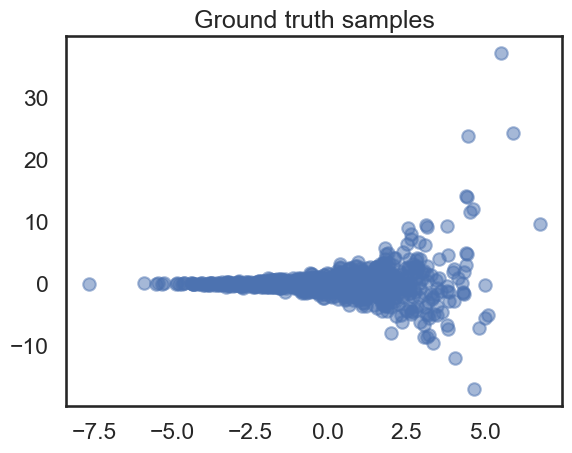

In [8]:
fig,ax=plt.subplots(1,1)
#cp = ax.contourf(X, Y, dens_vals)
#fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(True_samples[:,0],True_samples[:,1], alpha=0.5)
ax.set_title('Ground truth samples')
plt.show()

### Sample with NUTS

In [9]:
#samples to compute ground-truth metrics
Nuts_samples_ground_truth = 2000
#Nuts_samples_comparison
trunc_chain_len = 1000
#nuts samples burn_in
nuts_burn_in = 500
#nuts batch size
nuts_batch = 1

### Generate ground-truth samples (with NUTS)

In [10]:
random_seed(42)

sample_nuts_ref = NUTS(
    start, 
    target,
    n_samples=1000,
    burn_in=nuts_burn_in,
    step_size=0.1
).detach().cpu()
print(sample_nuts_ref.shape)

In [11]:
fig,ax=plt.subplots(1,1)
ax.scatter(sample_nuts_ref[:,0,0],sample_nuts_ref[:,0,1], alpha=0.5)
ax.set_title('NUTS samples')
plt.show()

In [12]:
metrics = compute_metrics(
                    True_samples,
                    sample_nuts_ref.numpy(),
                    name="NUTS",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

### Sample with Flex2MCMC (adaptive version)

In [74]:
params_flex = {
      "N": 200,
      "grad_step": 0.2,
      "adapt_stepsize": True,
      "corr_coef": 0.0,
      "bernoulli_prob_corr": 0.0,
      "mala_steps": 0,
    "flow": {
      "num_blocks": 4, # number of normalizing layers 
      "lr": 1e-3, # learning rate 
      "batch_size": 100,
      "n_steps": 1000,
    }
}
batch_size = 1
n_steps_flex2 = 1000

In [70]:
random_seed(42)

mcmc = Ex2MCMC(**params_flex, dim=dim)
verbose = mcmc.verbose
mcmc.verbose = False
flow = RNVP(params_flex["flow"]["num_blocks"], dim=dim, device = device)
#flow = MinimalRNVP(dim, device, num_blocks=4)

flow_mcmc = FlowMCMC(
    target,
    proposal,
    device,
    flow,
    mcmc,
    batch_size=params_flex["flow"]["batch_size"],
    lr=params_flex["flow"]["lr"],
)
flow.train()
out_samples, nll = flow_mcmc.train(
    n_steps=params_flex["flow"]["n_steps"],
)

flow.eval()

100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


RNVP(
  (flow): ModuleList(
    (0-3): 4 x AffineCoupling()
  )
)

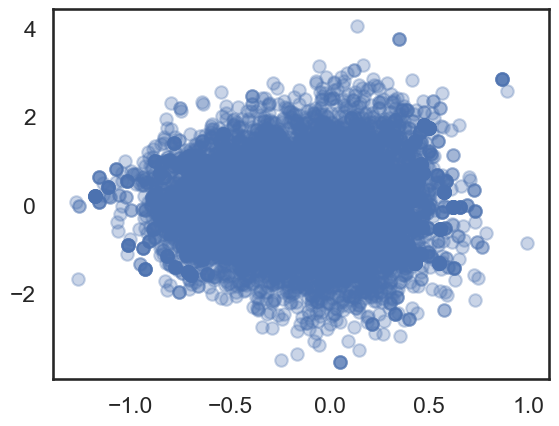

In [71]:
sample = torch.stack(out_samples, 0).detach().cpu()
plt.scatter(sample.view(-1, dim)[:, 0], sample.view(-1, dim)[:, 1], alpha=0.3)

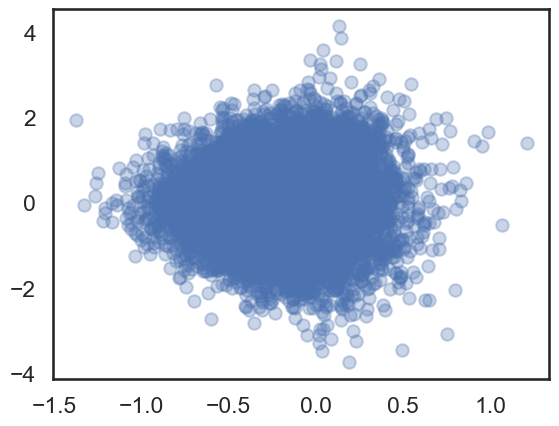

In [72]:
# for n, p in flow.named_parameters():
#     p.data = -p.data
sample = torch.randn((10000, 100))
sample, _ = flow.inverse(sample)
sample = sample.detach().cpu().numpy()

# sample = flow.sample((1000, )).detach().cpu().numpy()
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.3)

In [ ]:
#sample from a normalizing flow
random_seed(42)

mcmc.flow = flow
mcmc.verbose = verbose
n_steps_flex2 = 1 #000
batch_size = 1000
start = proposal.sample((batch_size,))
mcmc.N = 200
mcmc.grad_step = 0.1
mcmc.mala_steps = 3

out_new = mcmc(start, target, proposal, n_steps = n_steps_flex2)
out_new = out_new[0]
out_new = np.array(
    [_.detach().numpy() for _ in out_new],
).reshape(-1, batch_size, dim)
sample_flex2_final = out_new


100%|██████████| 1/1 [00:05<00:00,  5.22s/it]


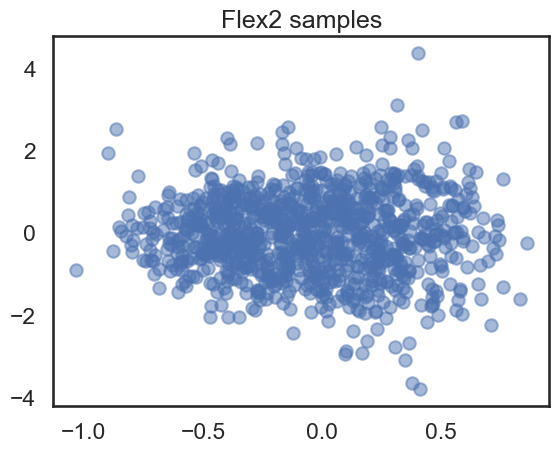

In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(sample_flex2_final.reshape(-1, dim)[:, 0], sample_flex2_final.reshape(-1, dim)[:, 1], alpha = 0.5)
ax.set_title('Flex2 samples')
plt.show()

In [77]:
sample_flex2_final, _ = ex2mcmc(start, target, flow, n_steps_flex2, 0, lambda x: x, target_acceptance=0.67, step_size=0.1, n_particles=200, n_mala_steps=3)
sample_flex2_final = sample_flex2_final.detach().cpu()

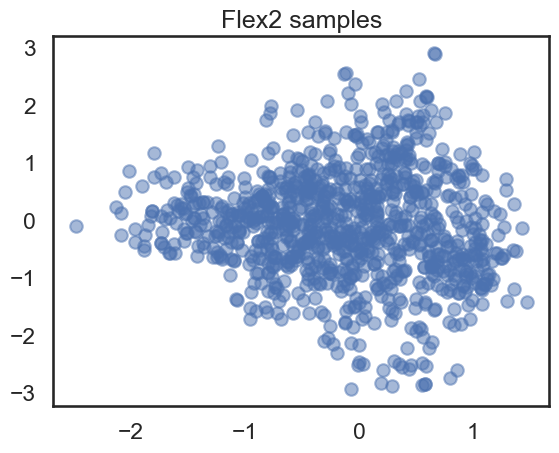

In [78]:
sample_flex2_final = sample_flex2_final.detach().cpu()

fig, ax = plt.subplots(1,1)
ax.scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,1],alpha = 0.5)
ax.set_title('Flex2 samples')
plt.show()

In [ ]:
metrics = compute_metrics(
                    True_samples,
                    sample_flex2_final,
                    name="Flex2",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

(1000, 100)
(1000, 1, 100)


  0%|          | 0/25 [00:00<?, ?it/s]

====Flex2====
TV distance. Mean: 0.060, Std: 0.018. 
ESS: 0.334 
EMD: 942.582


In [ ]:
dim = 200
loc_proposal = torch.zeros(dim).to(device)
scale_proposal = 1.0 * torch.ones(dim).to(device)
#scale_isir = scale_isir * torch.ones(dim).to(device)

proposal = MNormal(
        loc_proposal,
        scale_proposal * torch.eye(dim, device=device),
)

n_samples = 2000
random_seed(42)
sample_2 = proposal.sample((n_samples,))
sample_2 = sample_2.unsqueeze(1).cpu().numpy()
print(sample_2.shape)
sample_1 = proposal.sample((n_samples,)).cpu().numpy()
metrics = compute_metrics(
                    sample_1,
                    sample_2,
                    name="Gaussian noise",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

(2000, 1, 200)
(2000, 200)
(1000, 1, 200)


  0%|          | 0/25 [00:00<?, ?it/s]

====Gaussian noise====
TV distance. Mean: 0.035, Std: 0.009. 
ESS: 0.832 
EMD: 311.477


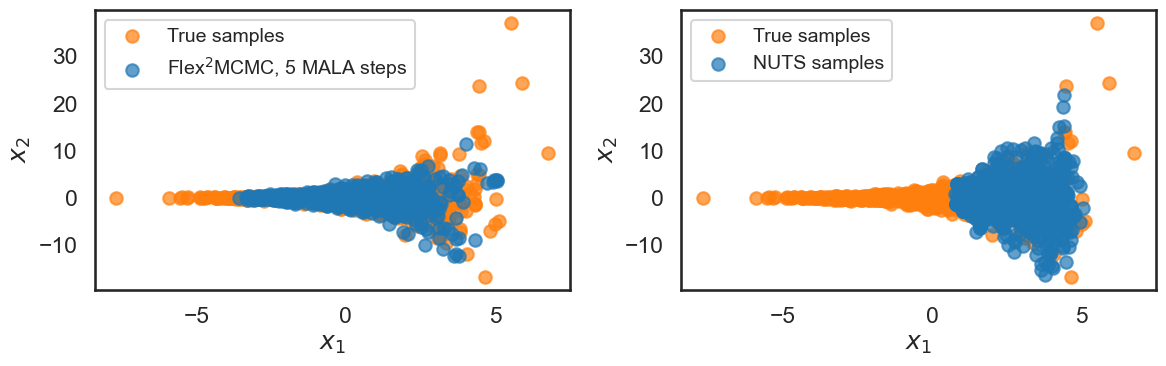

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(12,4))

axs[0].scatter(True_samples[:,0],True_samples[:,1],c='#ff7f0e', alpha = 0.7, label = "True samples")
axs[0].scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,1],c='#1f77b4', alpha = 0.7, label = "Flex$^2$MCMC, 5 MALA steps")
axs[1].scatter(True_samples[:,0],True_samples[:,1],c='#ff7f0e', alpha = 0.7, label = "True samples")
axs[1].scatter(sample_nuts_ref[:,0,0],sample_nuts_ref[:,0,1],c='#1f77b4', alpha = 0.7, label = "NUTS samples")

for ax in axs:
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.legend(fontsize=14)

fig.tight_layout()
plt.show()